In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def compare_anomaly_detection(df, predicted_col='HDBSCAN_Anomaly', 
                            actual_col='A_InvoiceAmount'):
    """
    Compare predicted anomalies with actual anomalies and display metrics
    
    Parameters:
    - df: DataFrame containing both predicted and actual anomaly columns
    - predicted_col: Name of the column containing predicted anomalies
    - actual_col: Name of the column containing actual anomalies
    
    Returns:
    - Dictionary containing confusion matrix and classification metrics
    """
    
    # Convert anomaly labels to binary format
    y_true = (df[actual_col] == 'anomaly').astype(int)
    y_pred = (df[predicted_col] == 'Yes').astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Create detailed metrics report
    metrics = {
        'Confusion Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'True Positives': tp
    }
    
    # Print detailed report
    print("\nDetailed Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print("\nConfusion Matrix Breakdown:")
    print(f"True Negatives (Normal correctly identified): {tn}")
    print(f"False Positives (Normal incorrectly flagged as anomaly): {fp}")
    print(f"False Negatives (Anomaly missed): {fn}")
    print(f"True Positives (Anomaly correctly identified): {tp}")
    
    # Create a more detailed analysis of misclassifications
    df['Classification_Result'] = 'Correct'
    df.loc[(y_true == 0) & (y_pred == 1), 'Classification_Result'] = 'False Positive'
    df.loc[(y_true == 1) & (y_pred == 0), 'Classification_Result'] = 'False Negative'
    
    # Analyze misclassifications by vendor
    misclassification_by_vendor = df[df['Classification_Result'].isin(['False Positive', 'False Negative'])]\
        .groupby(['fldVendorNo', 'Classification_Result']).size().unstack(fill_value=0)
    
    print("\nTop Vendors with Misclassifications:")
    print(misclassification_by_vendor.sort_values(by=['False Positive', 'False Negative'], 
                                                ascending=False).head())
    
    return metrics

In [5]:
def main():
    # Load the dataset
    df = pd.read_csv("vendor_specific_hdbscan_anomalies.csv")
    
    # Compare predicted vs actual anomalies
    metrics = compare_anomaly_detection(df)
    
    # Optional: Save detailed misclassification analysis
    misclassified = df[df['Classification_Result'].isin(['False Positive', 'False Negative'])]
    misclassified.to_csv("misclassified_cases.csv", index=False)

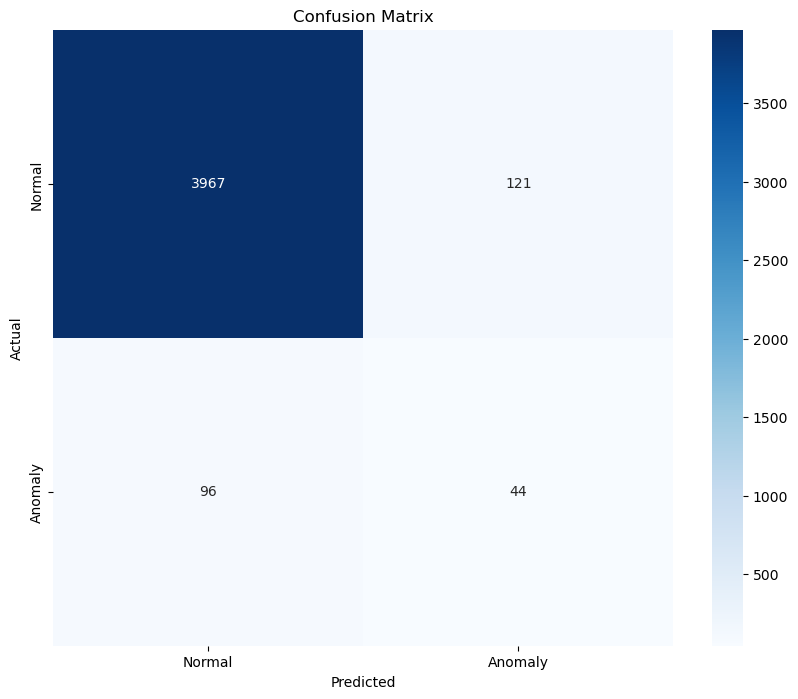


Detailed Metrics:
Accuracy: 0.949
Precision: 0.267
Recall: 0.314
F1 Score: 0.289

Confusion Matrix Breakdown:
True Negatives (Normal correctly identified): 3967
False Positives (Normal incorrectly flagged as anomaly): 121
False Negatives (Anomaly missed): 96
True Positives (Anomaly correctly identified): 44

Top Vendors with Misclassifications:
Classification_Result  False Negative  False Positive
fldVendorNo                                          
466360                              0              25
109371                              0              14
705016                              0              14
466379                              0               8
466417                              0               6


In [6]:
if __name__ == "__main__":
    main()